$\newcommand{\ket}[1]{\left|{#1}\right\rangle}$
$\newcommand{\bra}[1]{\left\langle{#1}\right|}$
$\newcommand{\floor}[1]{\left\lfloor #1 \right\rfloor}$
$\newcommand{\ceil}[1]{\left\lceil #1 \right\rceil}$
<h1 align="left" style="color: #cd7f32;">Quantum Input encoding  ---- </h1>
Given a vector $x=({x_1~y_1~x_2~y_2\dots~x_{n}~y_{n}})^T$ Where each couple $({x_i~y_i})^T$ represents the position satellite i
</br>
(https://github.com/Abderrahman-a/Predict-the-orbit-of-the-James-Webb-space-telescope-with-a-quantum-algorithm---Herman-Kolden) We want to encode it in a quantum state so that it can serve as an entry for the HHL algorithm.
</br>
There are multiple ways to do so.

<h2 align="left" style="color: #cd7f32;">Naive encoding</h2>
One simple naive way is to encode each satellite position in one qubit and then apply HHL on every qubit. But this will render the HHL speed up unatteinable since we will work with n system of sise 2 and thus the time we need to solve the problem would be $O(n)$

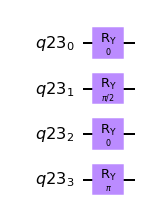

In [10]:
from qiskit import QuantumRegister, QuantumCircuit, execute, Aer
import numpy as np

def prepareState(initialStates):
    """
    This function constructs a circuit that initializes the entries to the given input vector
    
    Input:
    initialStates: (x1,y1,x2,y2,...,xn,yn) a vector representing the states of each individual qubits
    
    Output:
    - qc: A quantum circuit intializing each qubit i with the state given by initialStates[2i] and initialStates[2i+1]
    """
    nqubits = len(initialStates)//2
    qr = QuantumRegister(nqubits)
    qc = QuantumCircuit(qr)
    for i in range(nqubits):
        # Calculate theta with the right quadrant (   arctan2(y,x)   )
        theta = np.arctan2(initialStates[2*i+1],initialStates[2*i])
        qc.ry(2*theta, qr[i])#Try this also: qc.ry(2*angle,q[2])
    return qc


initialStates=[1,0,0.5**0.5,0.5**0.5,1,0,0,1]

circuit = prepareState(initialStates)

circuit.draw(output='mpl')


<div class="alert alert-block alert-info">
<b></b> Now, we will explore anathor alternative known as amplitude encoding
</div>

<h2 align="left" style="color: #cd7f32;">Amplitude Encoding</h2>

The idea is to prepare a quantum  state represented by the vector $$\tilde{x} = \frac{x}{norm(x)}$$.
</br>
Let assume $\tilde{x} = ({\tilde{x}_1~\tilde{x}_2~\dots~\tilde{x}_{N}})$ where $N=2n$ and $N=2^m$ where m is the number of qubits needed to represent the state
</br>
The output would be a quantum state wehre the aplitude of base vector $\ket{i}$ is equal to $\tilde{x}$
$$\ket{\psi}={\tilde{x}_1\ket{1}+\tilde{x}_2\ket{2}+\dots+\tilde{x}_{N}\ket{N}}$$
Multiple ways exist in literature to perform amplitude encoding. We will implement here the method based on uniformly controlled rotations gate explained in the references below:

- [1] <a id="ref1" href="https://arxiv.org/pdf/quant-ph/0407010.pdf">Transformation of quantum states using uniformly controlled rotations, Mikko M ̈ott ̈onen, Juha J. Vartiainen, Ville Bergholm, and Martti M. Salomaa</a>
- [2] <a id="ref2" href="https://www.nature.com/articles/s41598-021-85474-1.pdf">A divide‑and‑conquer algorithm for quantum state preparation,Israel F. Araujo1, Daniel K. Park, Francesco Petruccione & Adenilton J. da Silva</a>

First we need to define two function:
</br>
- gen_angles(x): this function takes the state vector to prepare an returns the sequence of angles of rotation around the y axis in the Bloch sphere to apply in order to obtain the state. 
- gen_circuit(angles): this function takes the list of angles and apply the corresponding uniformly controlled rotations (controlled by bits in state 0 and 1).
- level_index(k): this an auxillary function that given an integer k, $0<=k<=N-1$, returns the level at which the rotation should be

In [11]:
import numpy as np

def gen_angles(x):
    """
    This function generates the list of suitable angles to perform rotations  to obtain state represented by x
    
    Input:
    x : (x1,y1,x2,y2,...,xn,yn) a vector representing the digital representation of the state encoding the positions
    
    Output:
    - array of angles need to initialize the qubits to state x
    """
    if len(x)>1:
        new_x = np.zeros(len(x)//2)
        for k in range(len(new_x)):
            new_x[k] = np.sqrt(np.abs(x[2*k])**2+np.abs(x[2*k+1])**2)
        inner_angles = gen_angles(new_x)
        angles = np.zeros(len(x)//2)
        for k in range(len(new_x)):
            if new_x[k] != 0:
                if x[2*k] > 0:
                    angles[k] = 2*np.arcsin(x[2*k+1]/new_x[k])
                else:
                    angles[k] = 2*np.pi - 2*np.arcsin(x[2*k+1]/new_x[k])
            else:
                angles[k] = 0
        angles = np.concatenate((inner_angles,angles))
        return angles
    return np.array([])
x = np.array([np.sqrt(0.03),np.sqrt(0.07),np.sqrt(0.15),np.sqrt(0.05),np.sqrt(0.1),np.sqrt(0.3),np.sqrt(0.2),np.sqrt(0.1)])
angles = gen_angles(x)
print(np.round(angles,2))

[1.98 1.91 1.43 1.98 1.05 2.09 1.23]


<div class="alert alert-block alert-success">
Given the following input : $(\sqrt{0.03},\sqrt{0.07},\sqrt{0.15},\sqrt{0.05},\sqrt{0.1},\sqrt{0.3},\sqrt{0.2},\sqrt{0.1})$
, the expected output according to <a href="#ref2">[2]</a> is (1.98, 1.91, 1.43, 1.98, 1.05, 2.09, 1.23)
</div>


In [12]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute, Aer
from qiskit.circuit.library import RYGate
def level_index(k):
    """
    This function take an integer k and returns its level: the most significant bit in its binary representation, and the indices of the zero bits of its representation
    
    Input :
    k : integer
    
    Output:
    - Level: index of the most significant bit
    - indices : indices of zero bits of the binary representation of k
    """
    binary = np.binary_repr(k+1)
    level = len(binary)-1
    indices = []
    i = 0
    for c in binary[1:]:
        if c == '0':
            indices.append(i)
        i += 1
    return level , indices

def gen_circuit(angles):
    """
    This function genrates a circuit of uniformly controlled rotations
    Input:
    - angles : list of angles of rotation
    
    Output : 
    - qc : quantum circuit
    """
    nstates = np.ceil(np.log2(len(angles)+1))
    q  = QuantumRegister(nstates,'qreg')
    c  = ClassicalRegister(nstates,'c')
    qc = QuantumCircuit(q,c)
    last_level = 0
    qc.ry(angles[0],q[0])
    for k in range(1,len(angles)):
        level , index = level_index(k)
        if level != last_level:
            qc.barrier()
            last_level = level
        for i in index:
            qc.x(q[i])
        mcry = RYGate(angles[k]).control(level)
        qc.append(mcry, q[:level+1])
        for i in index:
            qc.x(q[i])
                    
    return qc

def amplitudeEncoding(x):
    """
    This function constructs the circuit performing amplitude encoding of a vector x
    
    Input:
    - x : vector to encoe
    
    Output:
    - circuit: Amplitude Encoding circuit
    """
    angles = gen_angles(x)
    circuit = gen_circuit(angles)
    return circuit

<h3 align="left" style="color: #cd7f32;">Testing the code</h3>
We consider the same input as before $\tilde{x}=(\sqrt{0.03},\sqrt{0.07},\sqrt{0.15},\sqrt{0.05},\sqrt{0.1},\sqrt{0.3},\sqrt{0.2},\sqrt{0.1})$

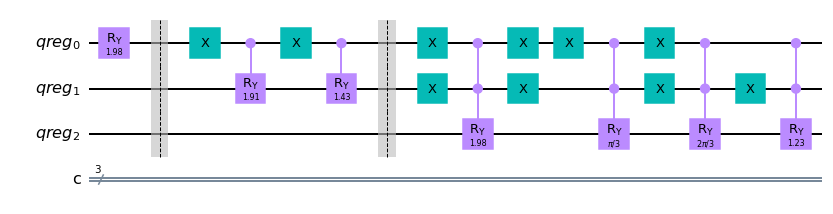

the state vector is
Input	Output
0.173 	 0.173
0.265 	 0.316
0.387 	 0.387
0.224 	 0.447
0.316 	 0.265
0.548 	 0.548
0.447 	 0.224
0.316 	 0.316


In [13]:
def test_code(x):
    qc = amplitudeEncoding(x)
    display(qc.draw(output='mpl'))

    job = execute(qc,Aer.get_backend('statevector_simulator'),optimization_level=0,shots=1)
    current_quantum_state=job.result().get_statevector(qc).data
    print("the state vector is")
    print("Input\tOutput")
    for i in range(len(current_quantum_state)):
        print(np.round(x[i],3),"\t",np.round(current_quantum_state[i].real,3))
    
x = np.array([np.sqrt(0.03),np.sqrt(0.07),np.sqrt(0.15),np.sqrt(0.05),np.sqrt(0.1),np.sqrt(0.3),np.sqrt(0.2),np.sqrt(0.1),])
test_code(x)


<div class="alert alert-block alert-warning">
The algorithm produces good results, except that they are swaped due to qiskit notation of bits.
</div>

<h4 align="left" style="color: #cd7f32;">Swaping the output bits</h4>

In [14]:
def gen_circuit(angles):
    """
    This function genrates a circuit of uniformly controlled rotations
    Input:
    - angles : list of angles of rotation
    
    Output : 
    - qc : quantum circuit
    """
    nstates = np.ceil(np.log2(len(angles)+1))
    q  = QuantumRegister(nstates,'qreg')
    c  = ClassicalRegister(nstates,'c')
    qc = QuantumCircuit(q,c)
    last_level = 0
    qc.ry(angles[0],q[0])
    for k in range(1,len(angles)):
        level , index = level_index(k)
        if level != last_level:
            qc.barrier()
            last_level = level
        for i in index:
            qc.x(q[i])
        mcry = RYGate(angles[k]).control(level)
        qc.append(mcry, q[:level+1])
        for i in index:
            qc.x(q[i])
    nstates = int(nstates)
    for i in range(nstates//2):
        qc.swap(q[i],q[-i-1])             
    return qc

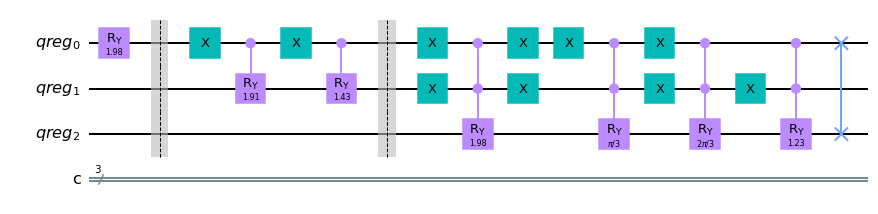

the state vector is
Input	Output
0.173 	 0.173
0.265 	 0.265
0.387 	 0.387
0.224 	 0.224
0.316 	 0.316
0.548 	 0.548
0.447 	 0.447
0.316 	 0.316


In [6]:
x = np.array([np.sqrt(0.03),np.sqrt(0.07),np.sqrt(0.15),np.sqrt(0.05),np.sqrt(0.1),np.sqrt(0.3),np.sqrt(0.2),np.sqrt(0.1),])
test_code(x)

</br>
<h4 align="left" style="color: #cd7f32;">Another test with a vector of size 2</h4>

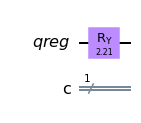

the state vector is
Input	Output
0.447 	 0.447
0.894 	 0.894


In [15]:
x = np.array([np.sqrt(0.2),np.sqrt(0.8)])
test_code(x)

</br>
<h4 align="left" style="color: #cd7f32;">And one last test with a $2^4=16$ vector</h4>

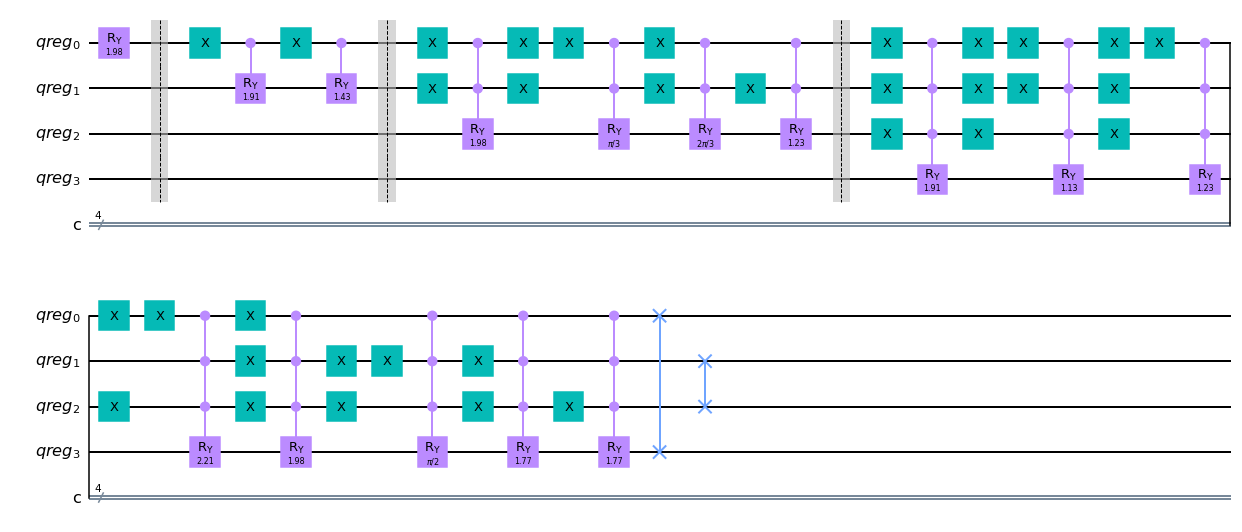

the state vector is
Input	Output
0.1 	 0.1
0.141 	 0.141
0.224 	 0.224
0.141 	 0.141
0.316 	 0.316
0.224 	 0.224
0.1 	 0.1
0.2 	 0.2
0.173 	 0.173
0.265 	 0.265
0.387 	 0.387
0.387 	 0.387
0.283 	 0.283
0.346 	 0.346
0.2 	 0.2
0.245 	 0.245


In [16]:
x = np.array([np.sqrt(0.01),np.sqrt(0.02),np.sqrt(0.05),np.sqrt(0.02),np.sqrt(0.1),np.sqrt(0.05),np.sqrt(0.01),np.sqrt(0.04),np.sqrt(0.03),np.sqrt(0.07),np.sqrt(0.15),np.sqrt(0.15),np.sqrt(0.08),np.sqrt(0.12),np.sqrt(0.04),np.sqrt(0.06)])
test_code(x)

</br>
<h3 align="left" style="color: #cd7f32;">How about some optimizations ?</h3>

<h4 align="left" style="color: #cd7f32;">NOT gates</h4>

We remark that to apply a target rotation on a bit when a control bit is in state $\ket{0}$ we combined a CRY gate with two NOT gates, one to ensure the rotation is performed when the control bit is in state $\ket{0}$ and the other to cancel the first NOT gate.
</br>
In many cases we perform two consecutive NOT gates, which are meaningless. Let's now get rid of the duplicated NOT gates

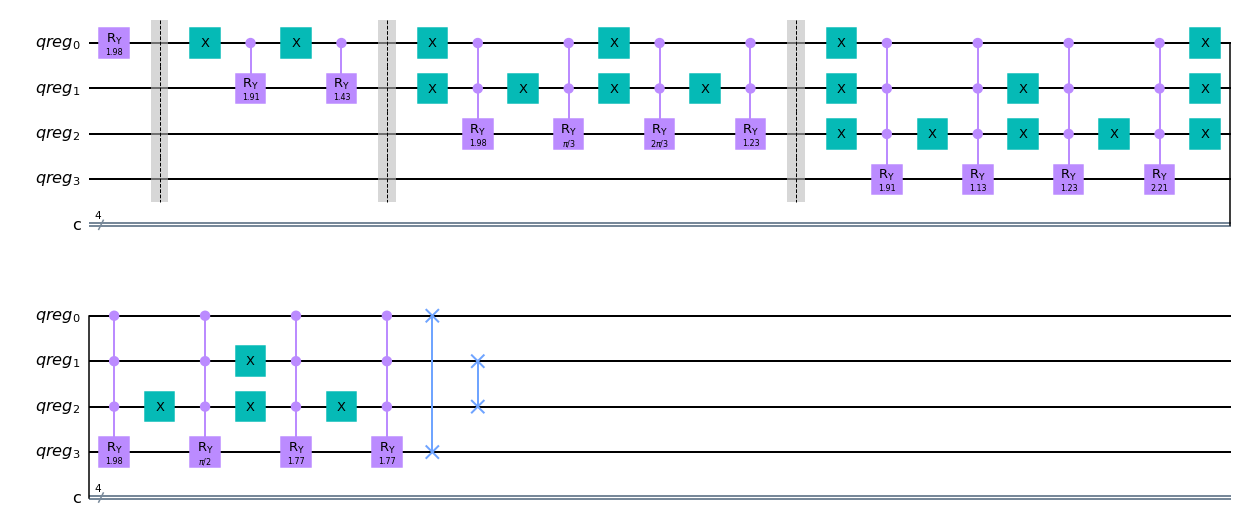

the state vector is
Input	Output
0.1 	 0.1
0.141 	 0.141
0.224 	 0.224
0.141 	 0.141
0.316 	 0.316
0.224 	 0.224
0.1 	 0.1
0.2 	 0.2
0.173 	 0.173
0.265 	 0.265
0.387 	 0.387
0.387 	 0.387
0.283 	 0.283
0.346 	 0.346
0.2 	 0.2
0.245 	 0.245


In [17]:
import numpy as np
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute, Aer
from qiskit.circuit.library import RYGate

def gen_circuit(angles):
    """
    This function genrates a circuit of uniformly controlled rotations
    Input:
    - angles : list of angles of rotation
    
    Output : 
    - qc : quantum circuit
    """
    nstates = np.ceil(np.log2(len(angles)+1))
    nstates = int(nstates)
    q  = QuantumRegister(nstates,'qreg')
    c  = ClassicalRegister(nstates,'c')
    qc = QuantumCircuit(q,c)
    last_level = 0
    qc.ry(angles[0],q[0])
    X = np.zeros(nstates)# 0 if NOT gate is not applied and 1 if NOT gate is applied
    for k in range(1,len(angles)):
        level , index = level_index(k)
        if level != last_level:
            qc.barrier()
            last_level = level
        for i in range(nstates):
            if i in index:
                if X[i] == 0:
                    qc.x(q[i])
                    X[i] = 1-X[i]
            else:
                if X[i] == 1:
                    qc.x(q[i])
                    X[i] = 1-X[i]
        mcry = RYGate(angles[k]).control(level)
        qc.append(mcry, q[:level+1])
        
    for i in range(nstates//2):
        qc.swap(q[i],q[-i-1])
                    
    return qc

x = np.array([np.sqrt(0.01),np.sqrt(0.02),np.sqrt(0.05),np.sqrt(0.02),np.sqrt(0.1),np.sqrt(0.05),np.sqrt(0.01),np.sqrt(0.04),np.sqrt(0.03),np.sqrt(0.07),np.sqrt(0.15),np.sqrt(0.15),np.sqrt(0.08),np.sqrt(0.12),np.sqrt(0.04),np.sqrt(0.06)])
test_code(x)

</br>

<h4 align="left" style="color: #cd7f32;">GRAY code</h4>


The Gray code allows minimal transitions from the representation of one integer to the next one, thus it can help reduce even more the NOT gates used by rearranging the controlled rotation since they can commute <a href="#ref1">[1]</a>.
In the example below, we will see the effect in Gray code only, to illustrate how gates controlled by bits in the same state would be arranged. And then we will eliminate the consecutive NOT gates in order see the improvement.

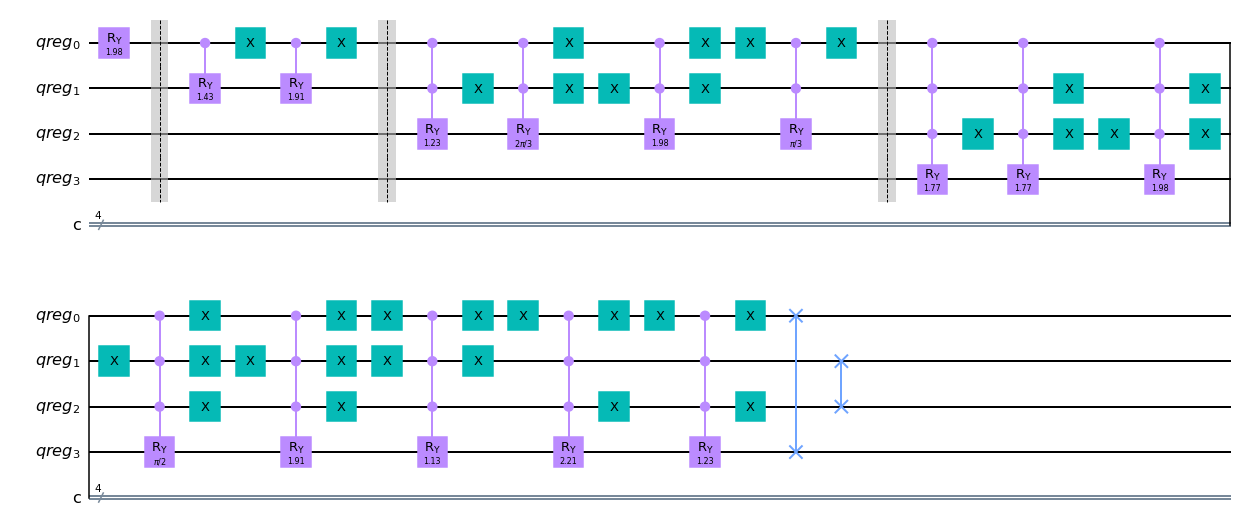

the state vector is
Input	Output
0.1 	 0.1
0.141 	 0.141
0.224 	 0.224
0.141 	 0.141
0.316 	 0.316
0.224 	 0.224
0.1 	 0.1
0.2 	 0.2
0.173 	 0.173
0.265 	 0.265
0.387 	 0.387
0.387 	 0.387
0.283 	 0.283
0.346 	 0.346
0.2 	 0.2
0.245 	 0.245


In [18]:
import numpy as np
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute, Aer
from qiskit.circuit.library import RYGate

def gen_circuit(angles):
    """
    This function genrates a circuit of uniformly controlled rotations
    Input:
    - angles : list of angles of rotation
    
    Output : 
    - qc : quantum circuit
    """
    new_angles = np.zeros(len(angles)+1)
    #new_angles[0] = angles[0]
    mapping = [0 for i in range(len(angles)+1)]
    for i in range(len(angles)):
        n = i+1
        n ^= (n >> 1)#Gray code of k+1
        new_angles[n] = angles[i]
        mapping[n] = level_index(i)
    n = len(angles)
    n ^= (n >> 1)
    #angles = np.delete(new_angles, n)
    angles = np.delete(new_angles, 0)
    del mapping[0]
        
    nstates = np.ceil(np.log2(len(angles)+1))
    nstates = int(nstates)
    q  = QuantumRegister(nstates,'qreg')
    c  = ClassicalRegister(nstates,'c')
    qc = QuantumCircuit(q,c)
    last_level = 0
    qc.ry(angles[0],q[0])
    for k in range(1,len(angles)):
        level , index = mapping[k]
        if level != last_level:
            qc.barrier()
            last_level = level
        for i in index:
            qc.x(q[i])
        mcry = RYGate(angles[k]).control(level)
        qc.append(mcry, q[:level+1])
        for i in index:
            qc.x(q[i])
    nstates = int(nstates)
    for i in range(nstates//2):
        qc.swap(q[i],q[-i-1])
                    
    return qc

x = np.array([np.sqrt(0.01),np.sqrt(0.02),np.sqrt(0.05),np.sqrt(0.02),np.sqrt(0.1),np.sqrt(0.05),np.sqrt(0.01),np.sqrt(0.04),np.sqrt(0.03),np.sqrt(0.07),np.sqrt(0.15),np.sqrt(0.15),np.sqrt(0.08),np.sqrt(0.12),np.sqrt(0.04),np.sqrt(0.06)])
test_code(x)

</br>

<h4 align="left" style="color: #cd7f32;">GRAY + NOT gates elimination</h4>



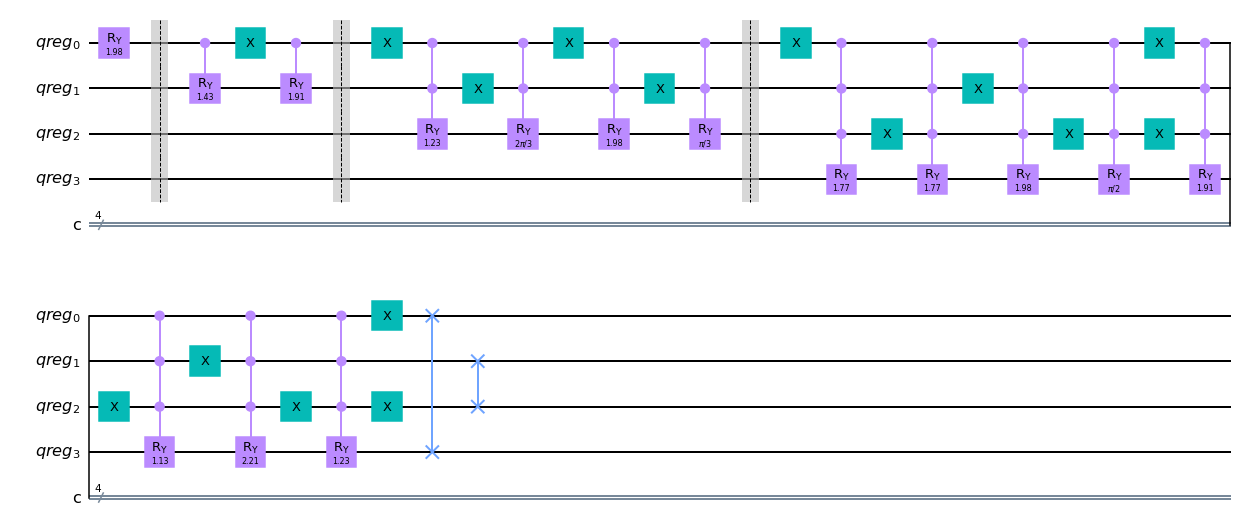

the state vector is
Input	Output
0.1 	 0.1
0.141 	 0.141
0.224 	 0.224
0.141 	 0.141
0.316 	 0.316
0.224 	 0.224
0.1 	 0.1
0.2 	 0.2
0.173 	 0.173
0.265 	 0.265
0.387 	 0.387
0.387 	 0.387
0.283 	 0.283
0.346 	 0.346
0.2 	 0.2
0.245 	 0.245


In [19]:
import numpy as np
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute, Aer
from qiskit.circuit.library import RYGate

def gen_circuit(angles):
    """
    This function genrates a circuit of uniformly controlled rotations
    Input:
    - angles : list of angles of rotation
    
    Output : 
    - qc : quantum circuit
    """
    new_angles = np.zeros(len(angles)+1)
    #new_angles[0] = angles[0]
    mapping = [0 for i in range(len(angles)+1)]
    for i in range(len(angles)):
        n = i+1
        n ^= (n >> 1)#Gray code of k+1
        new_angles[n] = angles[i]
        mapping[n] = level_index(i)
    n = len(angles)
    n ^= (n >> 1)
    #angles = np.delete(new_angles, n)
    angles = np.delete(new_angles, 0)
    del mapping[0]
        
    nstates = np.ceil(np.log2(len(angles)+1))
    nstates = int(nstates)
    q  = QuantumRegister(nstates,'qreg')
    c  = ClassicalRegister(nstates,'c')
    qc = QuantumCircuit(q,c)
    last_level = 0
    qc.ry(angles[0],q[0])
    X = np.zeros(nstates)# 0 if NOT gate is not applied and 1 if NOT gate is applied
    for k in range(1,len(angles)):
        level , index = mapping[k]
    X = np.zeros(nstates)# 0 if NOT gate is not applied and 1 if NOT gate is applied
    for k in range(1,len(angles)):
        level , index = mapping[k]
        if level != last_level:
            qc.barrier()
            last_level = level
        for i in range(nstates):
            if i in index:
                if X[i] == 0:
                    qc.x(q[i])
                    X[i] = 1-X[i]
            else:
                if X[i] == 1:
                    qc.x(q[i])
                    X[i] = 1-X[i]
        mcry = RYGate(angles[k]).control(level)
        qc.append(mcry, q[:level+1])
    for i in range(len(X)):
        if X[i] == 1:
            qc.x(q[i])
    #Because we swap the bits with the GRAY code we end up with som NOT gates not cancelled. We should undo them in order to get the correct result   
    for i in range(nstates//2):
        qc.swap(q[i],q[-i-1])
                    
    return qc

x = np.array([np.sqrt(0.01),np.sqrt(0.02),np.sqrt(0.05),np.sqrt(0.02),np.sqrt(0.1),np.sqrt(0.05),np.sqrt(0.01),np.sqrt(0.04),np.sqrt(0.03),np.sqrt(0.07),np.sqrt(0.15),np.sqrt(0.15),np.sqrt(0.08),np.sqrt(0.12),np.sqrt(0.04),np.sqrt(0.06)])
test_code(x)

The use of GRAY code and elimination NOT gates allowed us to reduce to total nuber of NOT gates from 34 to only 16 in the studied example.

<div class="alert alert-block alert-info">
The current quantum computers does not have a huge number of bits thus reducing the number of gates is essential to be able to implement this procedure.
</br>
Thre is another issue with the number of qubits that can be simultanusly be involved by a certain gate. due to stability issues <a href="#ref1">[1]</a> explains how we can transform uniformly controlled rotations that acts on n qubits on the same time into a combination of one qubit controlled rotation and CNOT gates.
</br>
Due to time limit,  we would not implment this optimization nor the one mentionned in <a href="#ref2">[2]</a>.
</div>

<h1 align="left" style="color: #cd7f32;">Quantum Vs Classical</h1>

With the computational complexity of state preparation determined, we consider the
complexity of the linear systems algorithm. In fact, the computation complexity of solving
linear systems is $O(n)$ on classical computers and $O(log(n))$ on quantum computers.

If a classical computer and a quantum computer both spent 1 seconds on solving
a $10 \times 10$ linear system, how long would it approximately take them each to solve $10^{12} \times 10^{12}$
a linear system?



- For the classical computer, the complextity is $O(n)$, meaning that $t_{classical}(n)=X_{classical}\times n$ where $X_{classical}$ is a constant to be determined
</br>Provinding that for $n=10,t=1s$, we find $X_{classical}=0.1$. Thus for a  $10^{12} \times 10^{12}$ system, $t_{classical}(10^{12})=0.1\times10^{12}=10^{11} s \approx 3169 years$

- For the quantum computer, the complextity is $O(log(n))$, meaning that $t_{quantum}(n)$ can be written as $t_{quantum}(n)=X_{quantum}\times log_{10}(n)$ where $X_{classical}$ is a constant to be determined
</br>Provinding that for $n=10,t=1s$, we find $X_{quantum}=1$. Thus for a  $10^{12} \times 10^{12}$ system, $t_{quantum}(10^{12})=1\times log(10^{12})=12 s$

<h1 align="left" style="color: #cd7f32;">Encoding complexity</h1>

<h2 align="left" style="color: #cd7f32;">Complexity of n multi-controlled rotations gate
</h2>
According to this <a href="https://arxiv.org/pdf/2109.06770.pdf">article</a>, the best existing decomposition algorithm and also the optimal theroritical limit offer the following complexity in terms of the number of elementary gates needed to create a n multi-qubit gate.

- $Ntheo(n) = \ceil{\frac{1}{4} (4^n − 3n − 1)}$
- $N(Optimized QDS)=\frac{23}{48} ·4^n − \frac{3}{2}2^n + \frac{4}{3}$

Thus, we need $O(2^n)$ elementary gates to decompose n multi-qubits gate.
This means there exist $M$ such as the number of elementary gates needed is inferior to $M2^n$

<h2 align="left" style="color: #cd7f32;">Complexity of the quantum amplitude encoding algorithm</h2>

Let $n$ be the state we want to encode; and $N$ the number of qubits needed for that, $N=\ceil{log_2(n)}$. Let's assume for simplicity that $N=log_2(n)$
 
- For k=1 we need: $1M2^1 = 2^{1-1}M2^1$ elementary gate
- For k=2 we need: $2M2^1  = 2^{2-1}M2^2$ additional elementary gates
</br>.
</br>.
</br>.
- For k=N we need $2 = 2^{N-1}M2^N=M2^{2N-1}$ addtional rotations

Thus the total number of rotations needed is 
$M\sum_{k=1}^{N} 2^{2k-1} = \frac{1}{6}M(2^{2N}-1)=O(2^N)=O(n)$
</br>
Thus the complexty of the algorithm is $O(n)$.

This means that the quantum advantage of the HHL algorithm ($O(log(n))$) connot be realised using such a method for preparing the states